In [13]:
import numpy as np
import os

from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit.circuit.library import *
from IPython.display import display, Math, Latex

from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

In [98]:
n=3
length = n**2
ans = ClassicalRegister(length)
q = QuantumRegister(length)
qc = QuantumCircuit(q, ans)

def index(i, j):
    return n*i+j

In [99]:
import random
def rand2d(rows, cols):
    return [[random.choice([+1, -1]) for _ in range(cols)] for _ in range(rows)]

def random_instance(length):
    # transverse field terms
    h = rand2d(length, length)
    # links within a row
    jr = rand2d(length - 1, length)
    # links within a column
    jc = rand2d(length, length - 1)
    return (h, jr, jc)

In [100]:
def prepare():
    for i in range(length):
        qc.reset(q[i])
        qc.h(q[i])

In [101]:
def rot_z_layer(h, half_turns):
    """Yields Z rotations by half_turns conditioned on the field h."""
    gate = ZGate().power(half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij == 1:
                qc.append(gate, [q[index(i,j)]])

In [102]:
def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    cz_gate = CZGate().power(half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            q_0 = q[index(i, j)]
            q_1 = q[index(i + 1, j)]
            if jr_ij == -1:
                qc.x(q_0)
                qc.x(q_1)
            qc.append(cz_gate, [q_0, q_1])
            if jr_ij == -1:
                qc.x(q_0)
                qc.x(q_1)

    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            q_0 = q[index(i, j)]
            q_1 = q[index(i, j + 1)]
            if jc_ij == -1:
                qc.x(q_0)
                qc.x(q_1)
            qc.append(cz_gate, [q_0, q_1])
            if jc_ij == -1:
                qc.x(q_0)
                qc.x(q_1)

                
def rot_x_layer(half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""
    rot = XGate().power(half_turns)

    for i in range(length):
        qc.append(rot, [q[i]])

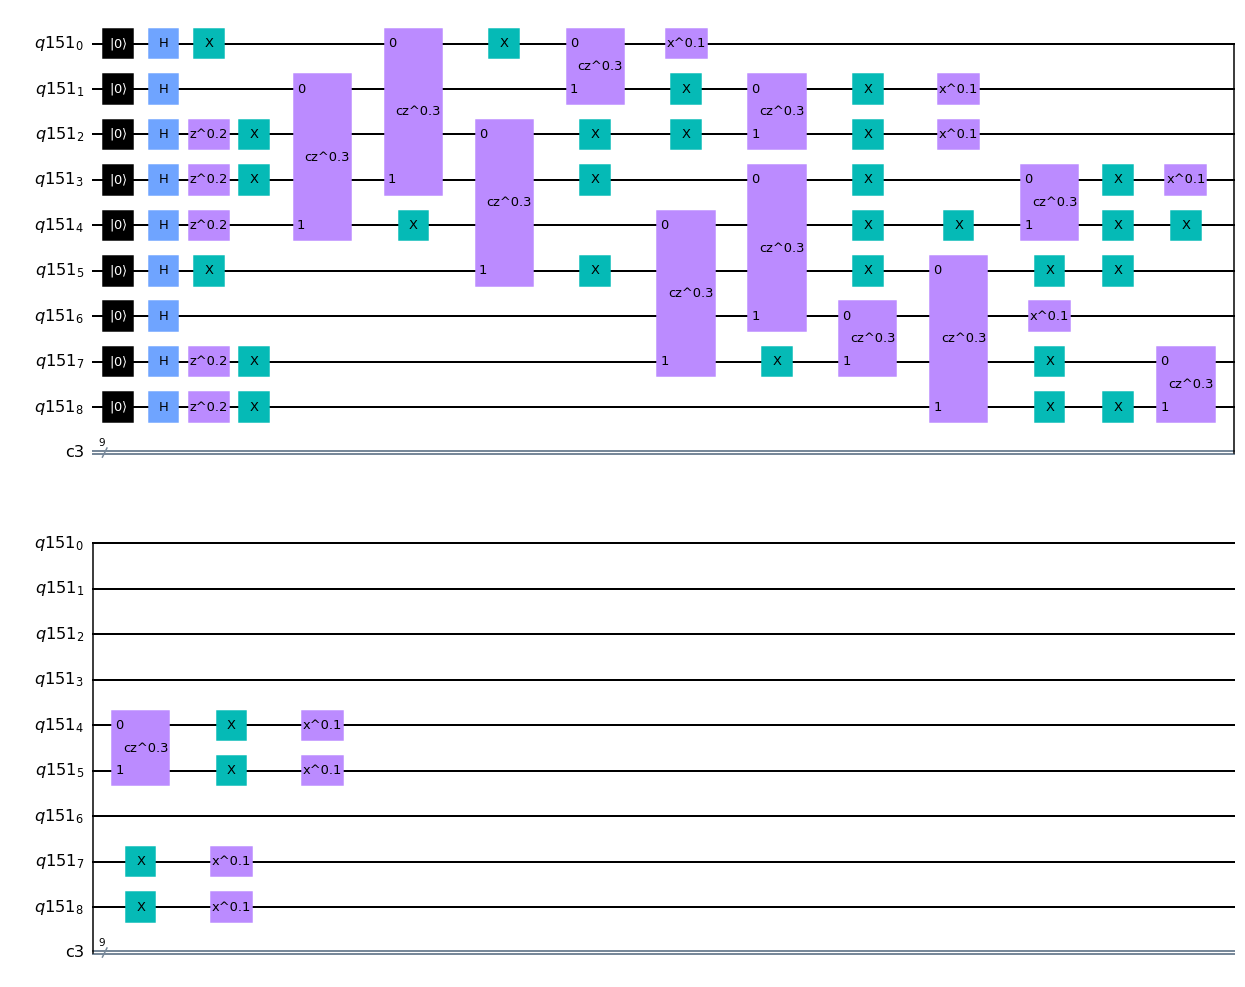

In [103]:
def initial_step():
    prepare()

def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
    rot_z_layer(h, h_half_turns)
    rot_11_layer(jr, jc, j_half_turns)
    rot_x_layer(x_half_turns)

h, jr, jc = random_instance(n)
initial_step()
one_step(h, jr, jc, 0.1, 0.2, 0.3)
cplot=qc.draw(output='mpl')
display(cplot)

In [104]:
for j in range(length):
    qc.measure(q[j], ans[j])

In [110]:
backend=BasicAer.get_backend('qasm_simulator')
job  = execute(qc, backend=backend, shots=2000)
result = job.result()


counts = result.get_counts()
trans_counts = {}
for key in counts:
    trans_counts[int('0b' + key, 2)] = counts[key]
print(trans_counts)

{106: 4, 268: 7, 501: 5, 58: 9, 54: 6, 130: 6, 237: 9, 180: 15, 397: 5, 340: 13, 316: 7, 371: 17, 415: 3, 181: 19, 141: 4, 208: 1, 231: 3, 310: 4, 341: 14, 469: 8, 82: 4, 429: 7, 158: 6, 339: 10, 117: 13, 227: 6, 312: 7, 172: 12, 293: 9, 285: 8, 107: 2, 369: 14, 189: 9, 184: 8, 299: 5, 182: 5, 142: 10, 244: 3, 197: 3, 99: 2, 332: 5, 50: 3, 451: 4, 249: 2, 252: 5, 308: 6, 471: 2, 60: 12, 425: 9, 373: 13, 394: 8, 51: 5, 148: 4, 424: 5, 278: 8, 127: 2, 405: 10, 154: 2, 116: 6, 175: 5, 399: 5, 121: 4, 56: 7, 270: 6, 178: 7, 163: 10, 110: 4, 374: 3, 284: 13, 198: 5, 422: 4, 102: 5, 317: 12, 338: 6, 428: 15, 4: 1, 264: 2, 346: 4, 109: 2, 383: 2, 343: 8, 470: 3, 242: 2, 176: 8, 282: 11, 277: 26, 41: 5, 230: 7, 98: 5, 185: 12, 398: 9, 149: 10, 267: 7, 305: 16, 120: 4, 233: 5, 112: 8, 171: 11, 291: 5, 464: 1, 174: 5, 168: 8, 494: 5, 235: 4, 423: 4, 276: 8, 337: 6, 377: 2, 202: 4, 93: 5, 55: 3, 453: 3, 300: 9, 342: 9, 111: 2, 84: 4, 426: 17, 228: 3, 273: 6, 476: 5, 162: 7, 306: 8, 262: 3, 433: 6

In [111]:
def energy_func(length, h, jr, jc):
    def energy(measurements):
        # Reshape measurement into array that matches grid shape.
        meas_list_of_lists = [measurements[i * length:(i + 1) * length]
                              for i in range(length)]
        # Convert true/false to +1/-1.
        pm_meas = 1 - 2 * np.array(meas_list_of_lists).astype(np.int32)

        tot_energy = np.sum(pm_meas * h)
        for i, jr_row in enumerate(jr):
            for j, jr_ij in enumerate(jr_row):
                tot_energy += jr_ij * pm_meas[i, j] * pm_meas[i + 1, j]
        for i, jc_row in enumerate(jc):
            for j, jc_ij in enumerate(jc_row):
                tot_energy += jc_ij * pm_meas[i, j] * pm_meas[i, j + 1]
        return tot_energy
    return energy

convert = energy_func(n, h, jr, jc)
res = convert(trans_counts)

TypeError: unhashable type: 'slice'